In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt 

from crowd_tracker_lidar3d.loader import load_data_to_dataframe
from crowd_tracker_lidar3d.plot_tools import plot_pointcloud3d, draw_point_cloud, show_projections
from crowd_tracker_lidar3d.preprocessing import rotate_pcl, df_apply_rot, return_ground_points, remove_ground_points
import matplotlib.pyplot as plt 

In [3]:
filename = '1m_1person-front_lidar-velodyne_points'

In [4]:
bag_dir = os.path.dirname(os.path.abspath(''))
bag_dir = os.path.join(bag_dir, "data")
data = load_data_to_dataframe(filename, bag_dir)

### Data Overview

In [5]:
data.shape

(8708643, 6)

In [6]:
data.head()

,rosbagTimestamp,x,y,z,intensity,time
0,1585676343998862698,1.316860,0.683471,-0.397546,52.0,-0.099374
1,1585676343998862698,1.278028,0.663033,0.025131,47.0,-0.099372
2,1585676343998862698,1.489500,0.772413,-0.387366,47.0,-0.099370
3,1585676343998862698,2.275012,1.179255,0.134294,8.0,-0.099367
4,1585676343998862698,1.352574,0.701108,-0.296136,31.0,-0.099365


In [7]:
# investigate value ranges
x_max, x_min = np.max(data.x), np.min(data.x)
y_max, y_min = np.max(data.y), np.min(data.y)
z_max, z_min = np.max(data.z), np.min(data.z)
intensity_max, intensity_min = np.max(data.intensity), np.min(data.intensity)

print('x_max: {:.3f}, x_min: {:.3f}'.format(x_max, x_min))
print('y_max: {:.3f} y_min: {:.3f}'.format(y_min, y_max))
print('z_max: {:.3f}, z_min: {:.3f}'.format(z_max, z_min))
print('intensity_max: {:.3f}, intensity_min: {:.3f}'.format(intensity_max, intensity_min))
print('\nNumber of points: {}'.format(data.shape[0]))

x_max: 24.399, x_min: -5.037
y_max: -6.674 y_min: 4.692
z_max: 6.045, z_min: -0.526
intensity_max: 144.000, intensity_min: 0.000

Number of points: 8708643


In [8]:
# Number of unique timestamps
timesteps = data.rosbagTimestamp.unique()
len(timesteps)

431

In [9]:
# Analyze pointclouds from first and very last timestamp
start = data[data.rosbagTimestamp == timesteps[0]]
end = data[data.rosbagTimestamp == timesteps[-1]]

In [10]:
print(len(start))
print(len(end))

20302
20216


In [14]:
%matplotlib inline

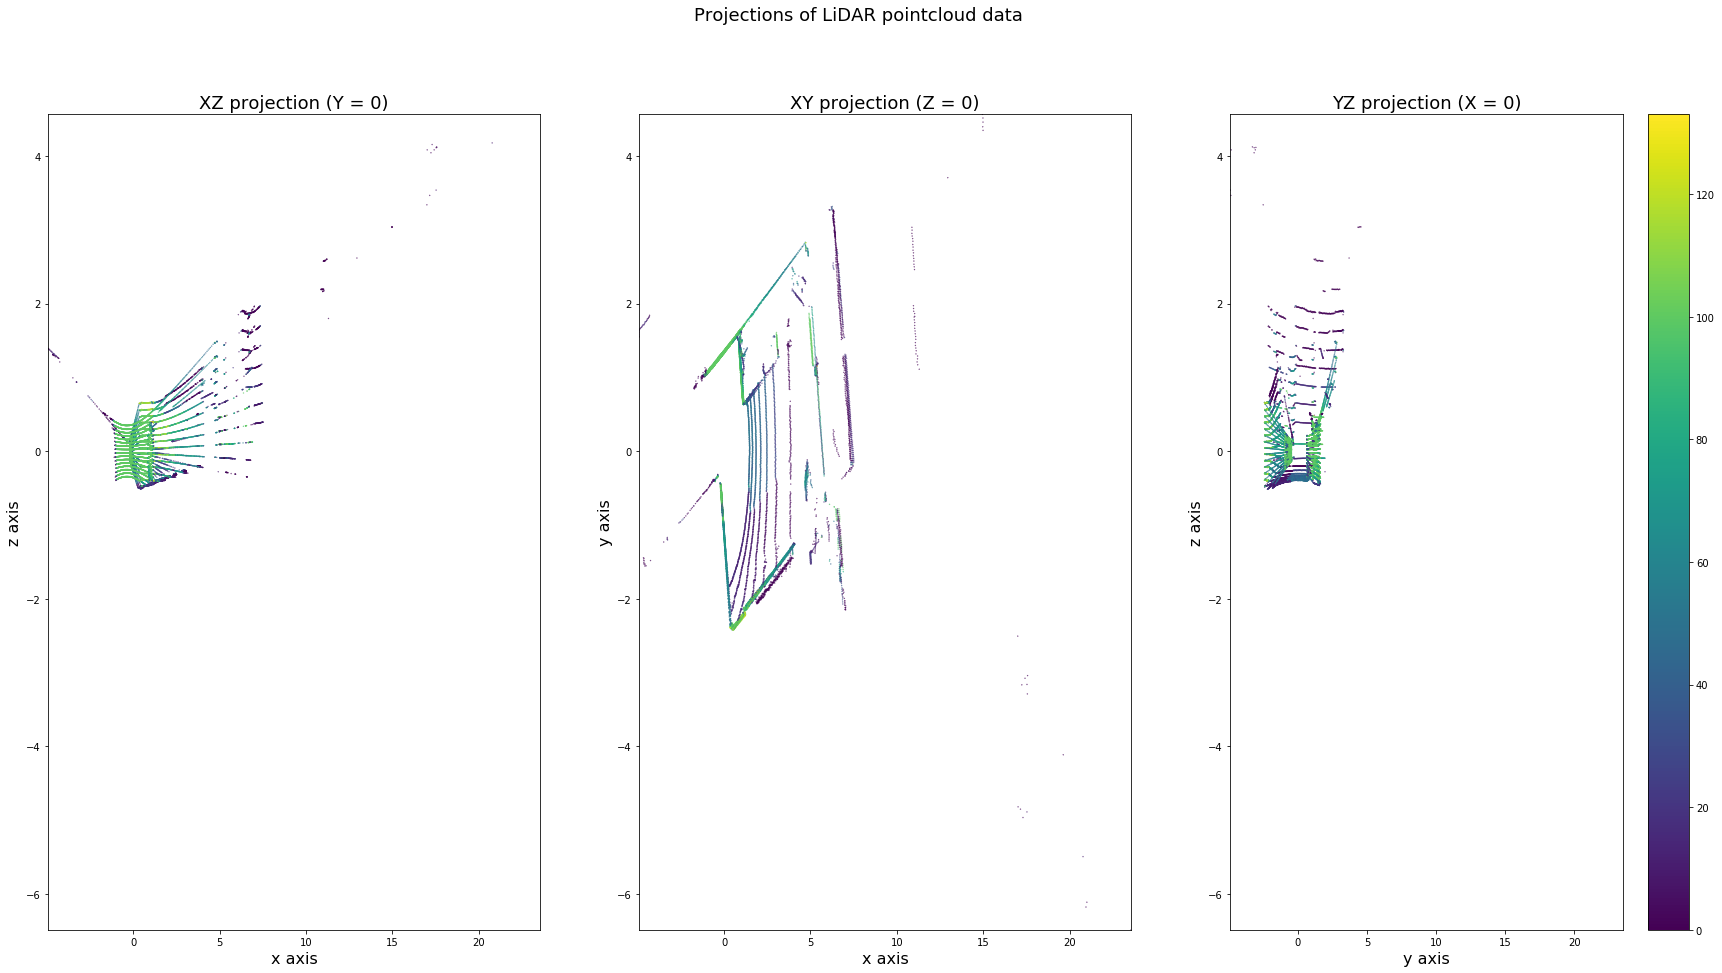

In [15]:
show_projections(start, ['x', 'y', 'z', 'intensity']) #savefig=True, filename='unfiltered_timestep0')

### Transform data set and filter floor points

In [16]:
# Set threshold in z-value 
thresh = -0.38

In [17]:
# Rotate points to compensate for LiDAR tilt angle 
start_transformed = df_apply_rot(start)

In [18]:
# Mean difference of z values before and after transformation
np.mean(start_transformed.z - start.z)

-0.11460865780910513

Total number of data points: 20302
Number of data points after filtering for floor points: 15977


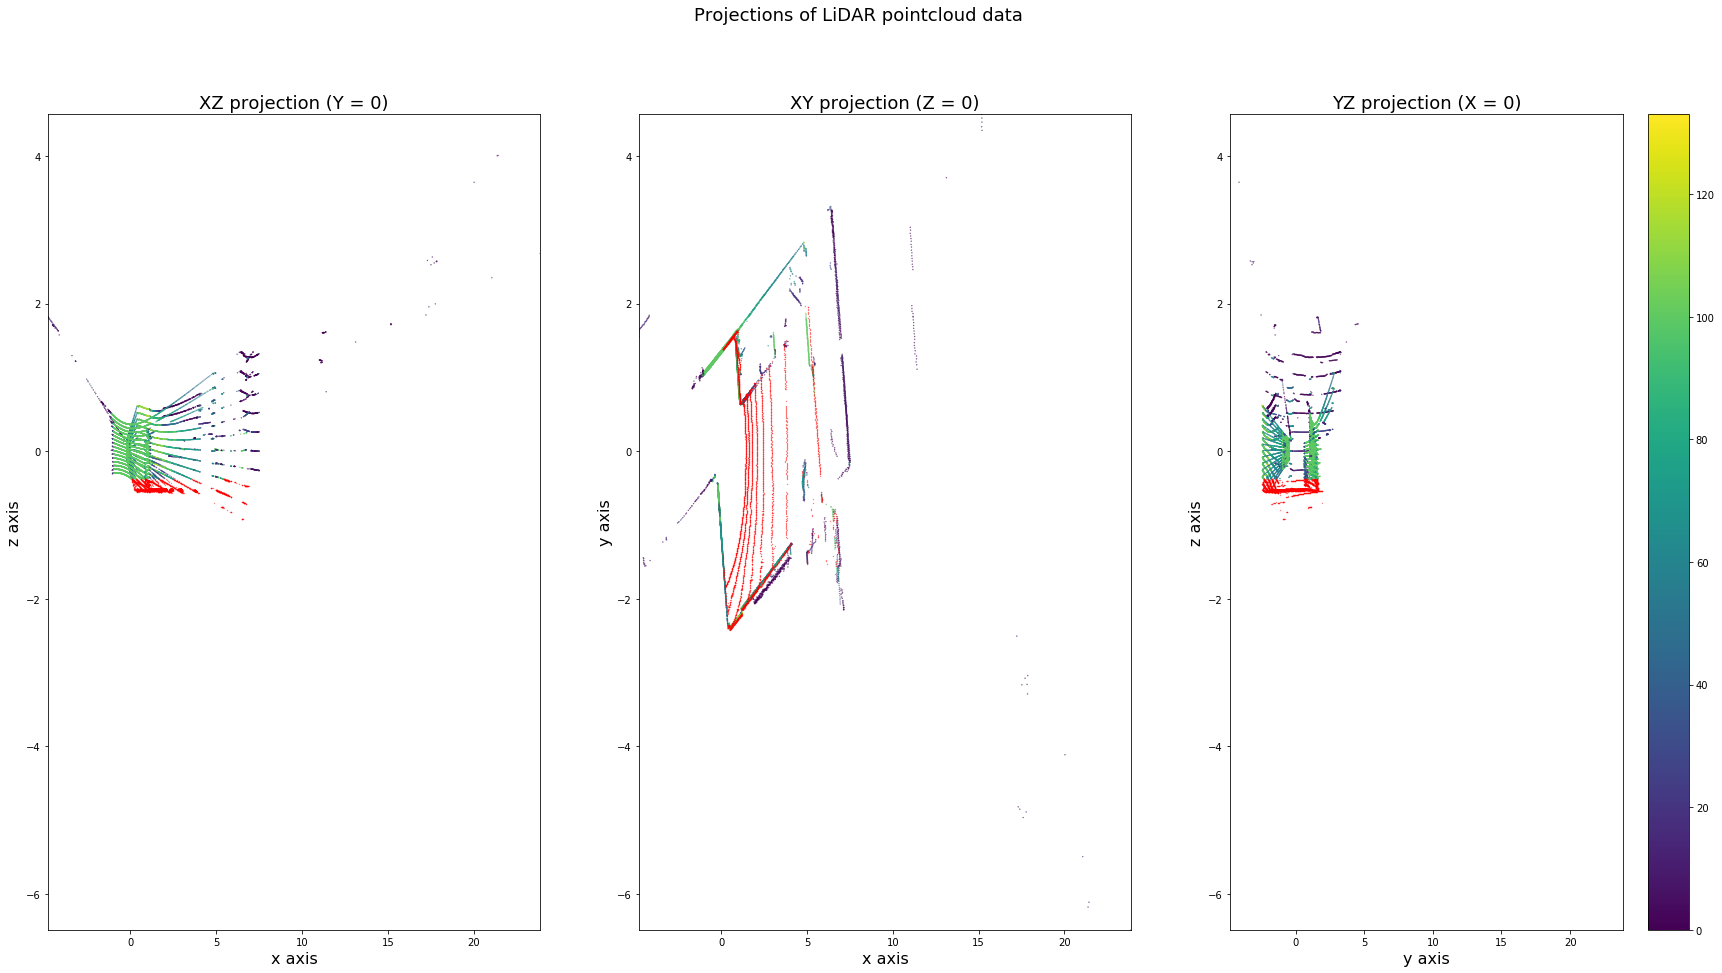

Filtered floor points


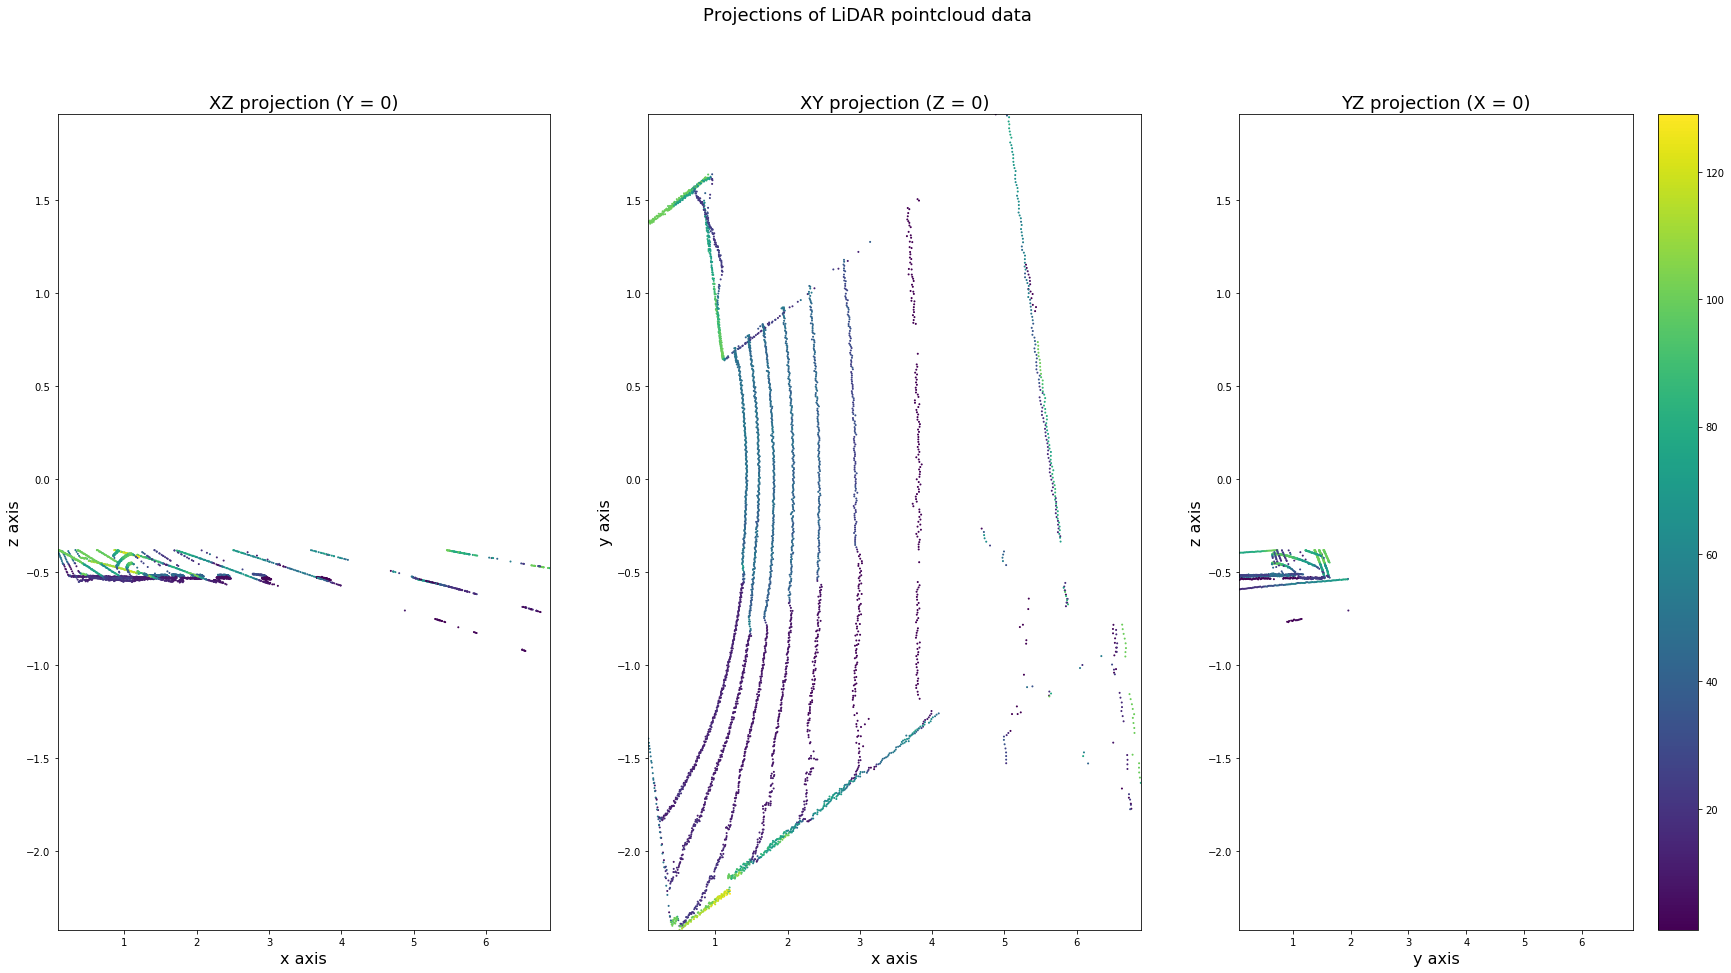

Points selected for segmentation after filtering out floor points


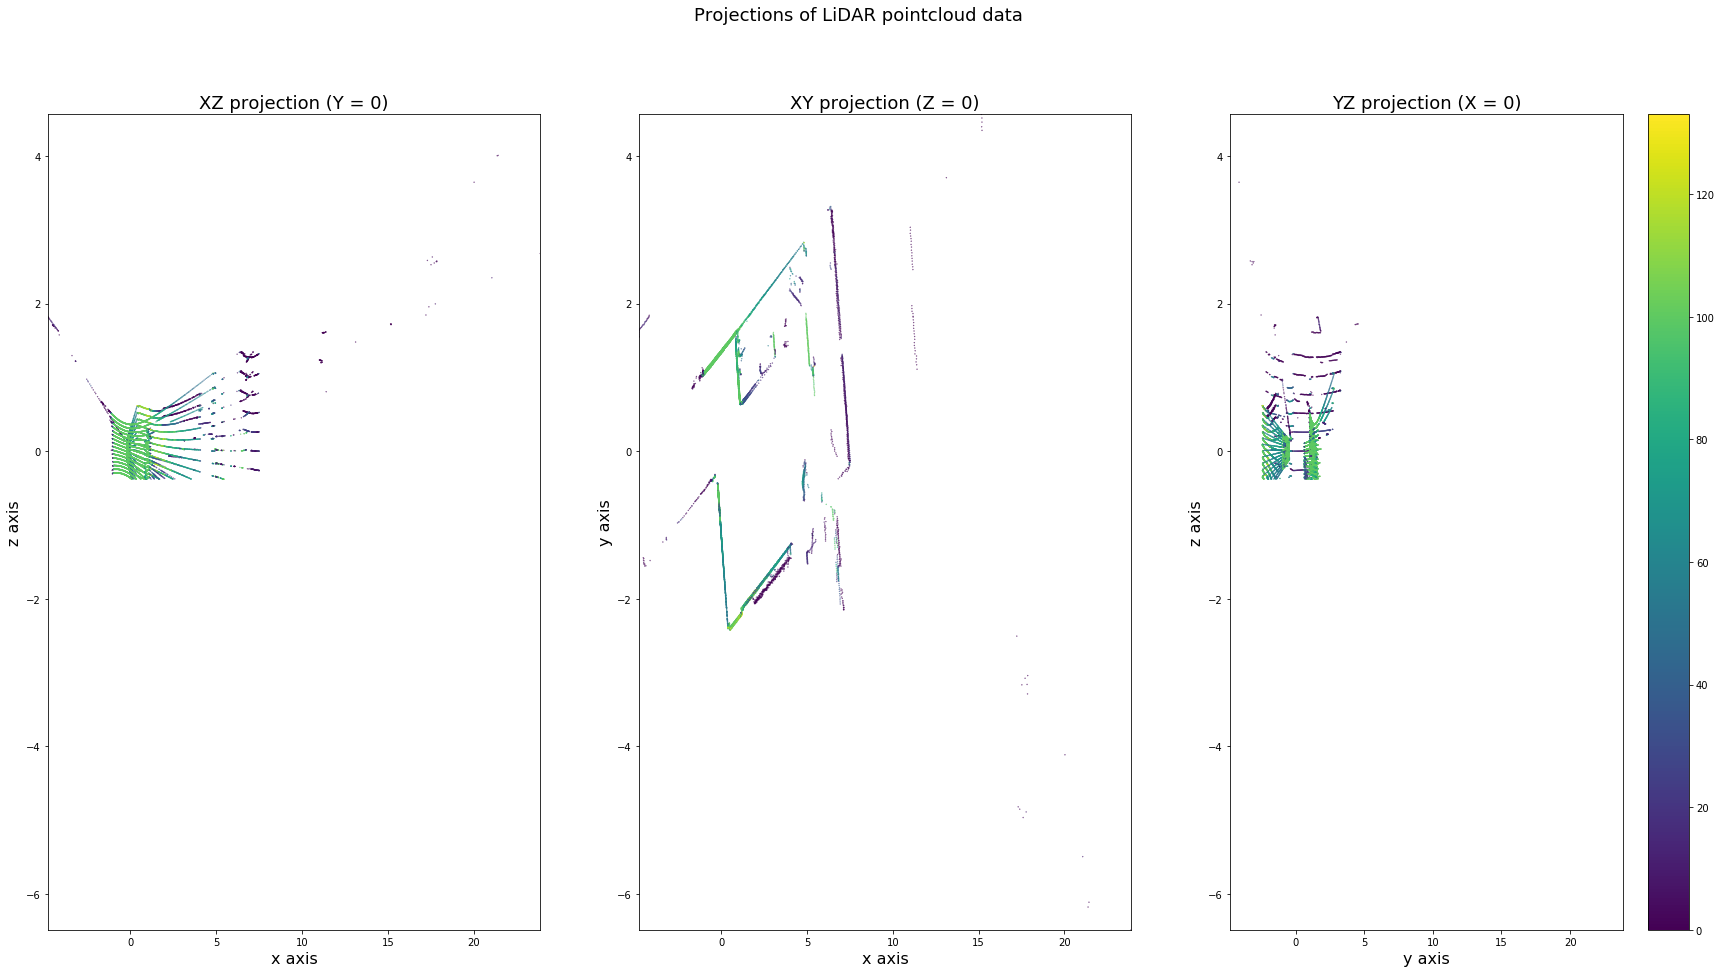

In [19]:
%matplotlib inline
ground_vals_after_rot = return_ground_points(start_transformed, thresh)
start_filtered = remove_ground_points(start_transformed, thresh)
print('Total number of data points: {}\nNumber of data points after filtering for floor points: {}'.format(start_transformed.shape[0], start_filtered.shape[0]))
show_projections(start_filtered, ['x', 'y', 'z', 'intensity'], point_eliminations=ground_vals_after_rot) #, savefig=True, filename='test')
print('Filtered floor points')
show_projections(ground_vals_after_rot, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='floorpoints_rotated_timestep0_z=-0mm')
print('Points selected for segmentation after filtering out floor points')
show_projections(start_filtered, ['x', 'y', 'z', 'intensity']) #savefig=True, filename='data_wo_floor_rotated_timestep0_z=-380mm')

### SEGMENTATION - Clustering

In [20]:
# Data 
cluster_data = start_filtered.to_numpy()
print(cluster_data.shape)

(15977, 4)


In [21]:
from sklearn.cluster import DBSCAN
# eps = search radius -- most important hyperparam of dbscan 
# choose eps as 5x/10x/... point cloud resolution which is ~+/-3cm within 10m
clustering = DBSCAN(eps=0.45,min_samples=30, leaf_size=30, algorithm='kd_tree').fit(cluster_data)

In [22]:
labels = clustering.labels_
#  Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 26
Estimated number of noise points: 5469


In [32]:
# Activate interactive plotting mode to be able to zoom in 
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


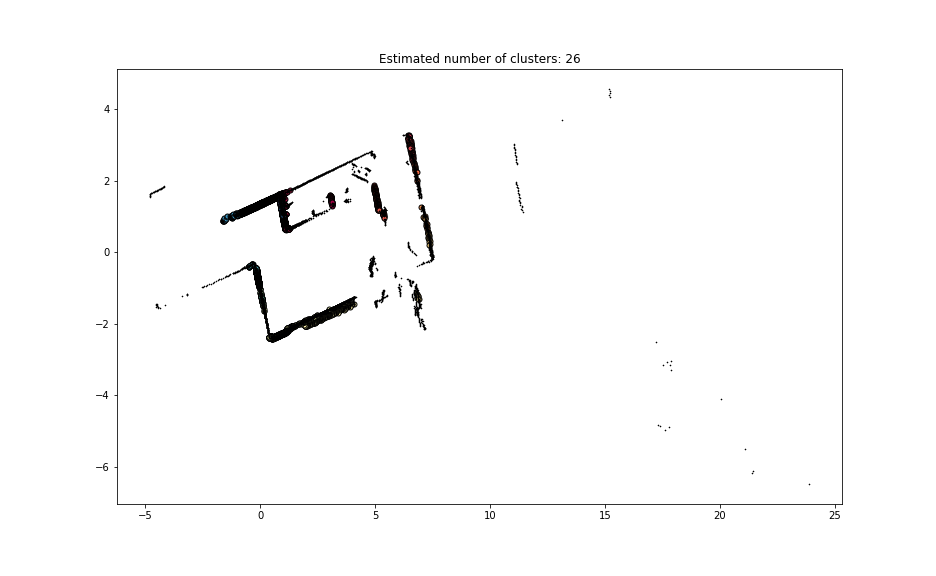

In [31]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

fig = plt.figure(figsize=[13, 8])

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = cluster_data[class_member_mask & core_samples_mask]
    
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = cluster_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

<IPython.core.display.Javascript object>


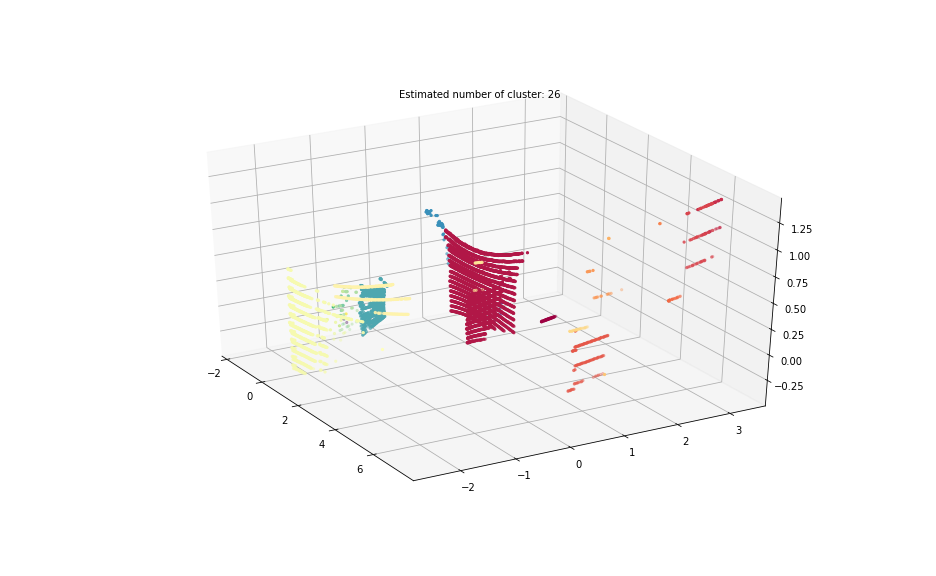

In [30]:
fig = plt.figure(figsize=[13, 8])
ax = fig.add_subplot(111, projection='3d')
# unique_labels = set(labels)
colors = [plt.cm.Spectral(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):  
    if k == -1:    # Black used for noise.    
        col = [0, 0, 0, 1]  
    class_member_mask = (labels == k)  
    xyz = cluster_data[class_member_mask & core_samples_mask]  
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=col, marker=".")
plt.title('Estimated number of cluster: %d' % n_clusters_, fontsize=10)
plt.show()

## Preprocessing - Testing
Testing a ground plane segmentation approach taken from [here](https://towardsdatascience.com/point-cloud-data-simple-approach-f3855fdc08f5)

In [145]:
dataset.shape

(20302, 3)

In [150]:
dataset[:, 2].min()

-0.5173874497413635

In [18]:
def frange(start, stop, step):  
    i = start  
    while i < stop:    
        yield i    
        i += step

dataset = start_transformed[['x', 'y','z']].copy().to_numpy()

#ground points grid filter
n = 100 #grid step
dataset_Z_filtered = dataset[[0]]
print(dataset_Z_filtered)

#setting height filtered from ground
zfiltered = (dataset[:, 2].max() - dataset[:, 2].min())/10 
print('zfiltered = ', zfiltered)

xstep = (dataset[:, 0].max() - dataset[:, 0].min())/n
ystep = (dataset[:, 1].max() - dataset[:, 1].min())/n

for x in frange (dataset[:, 0].min(), dataset[:, 0].max(), xstep):  
    for y in frange (dataset[:, 1].min(), dataset[:, 1].max(), ystep):    
        datasetfiltered = dataset[(dataset[:,0] > x)
                                 &(dataset[:, 0] < x+xstep)
                                 &(dataset[:, 1] > y)
                                 &(dataset[:, 1] < y+ystep)]    
        if datasetfiltered.shape[0] > 0:      
            datasetfiltered = datasetfiltered[datasetfiltered[:, 2]
                                >(datasetfiltered[:, 2].min()+ zfiltered)]      
            if datasetfiltered.shape[0] > 0:        
                dataset_Z_filtered = np.concatenate((dataset_Z_filtered, datasetfiltered))

print('dataset_Z_filtered shape', dataset_Z_filtered.shape)

[[ 1.33586141  0.68347061 -0.32808222]]
('zfiltered = ', 0.7446721758076336)
('dataset_Z_filtered shape', (2108, 3))


In [20]:
import pandas as pd
df_filter = pd.DataFrame(dataset_Z_filtered, columns=['x', 'y', 'z'])

### 3D Plot using matplotlib

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


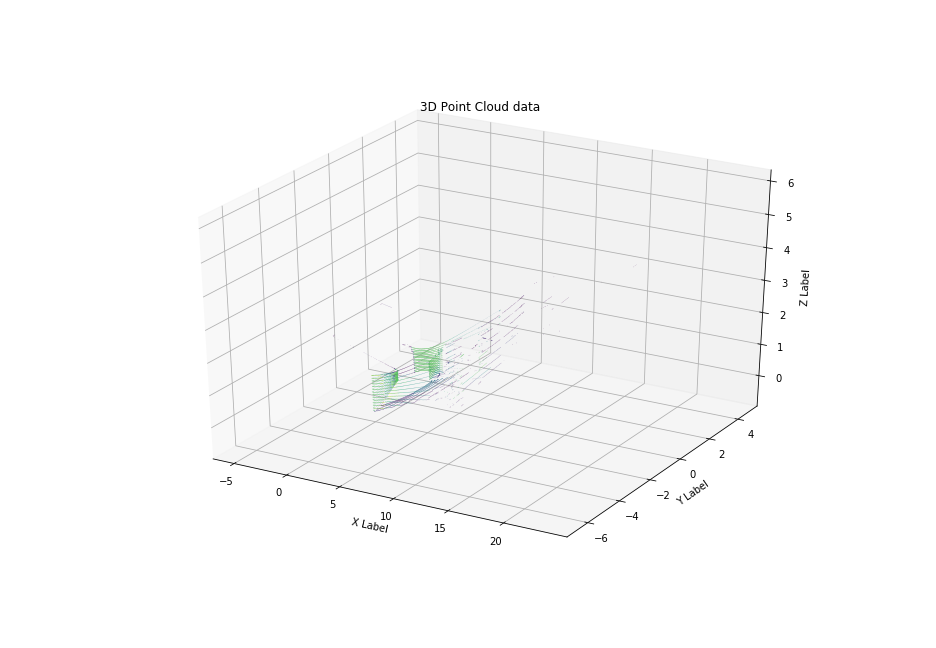

In [36]:
plot_pointcloud3d(start)

<IPython.core.display.Javascript object>


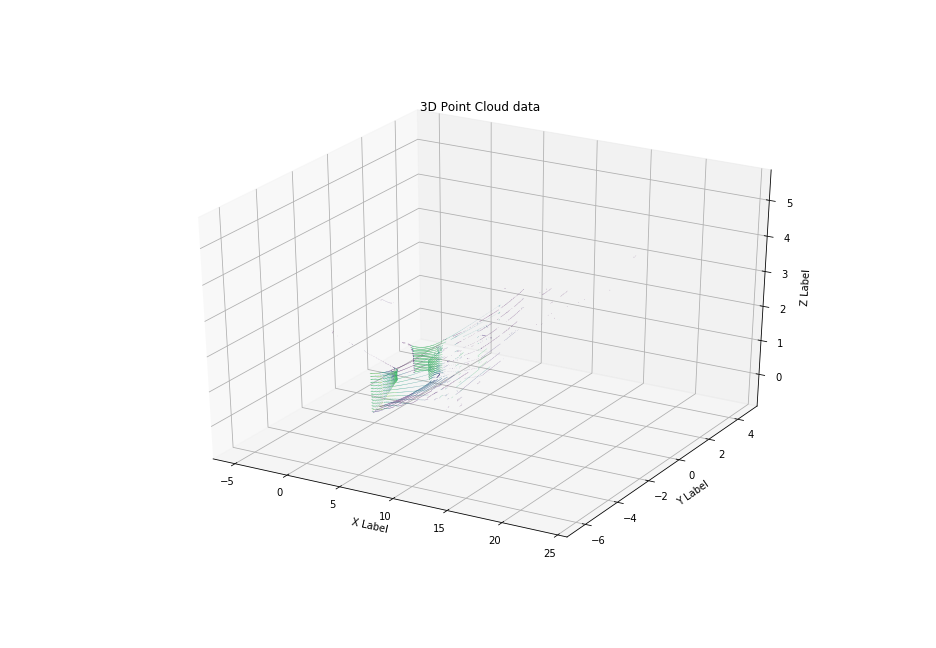

In [37]:
plot_pointcloud3d(end)

### 3D Plot using pptk
See documentation [here](https://heremaps.github.io/pptk/index.html). 
Example screenshot of interactive 3D visualzation:
<img src="files/pcl_1585676368204491882.png">

In [140]:
import pptk

In [14]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001)

In [46]:
v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(timesteps[0])))

In [31]:
len(timesteps)

431

In [36]:
# take only every 20th timestep
subsample = timesteps[::20]

In [56]:
len(subsample)

22

In [55]:
# save screenshot of lidar 3D plot for each timestep 
import time
for t in subsample: 
    pcl = data[data.rosbagTimestamp == t]
    v = pptk.viewer(pcl[['x', 'y', 'z']]) 
    v.attributes(pcl['intensity'])
    v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)    
    time.sleep(3)
    v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(t)))
    time.sleep(3)
    v.close()

In [88]:
v = pptk.viewer(start_ground[['x', 'y', 'z']]) 
v.attributes(start_ground['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)

In [141]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)